# Importiere Daten


In [155]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os
import seaborn as sns

## Funktionen definieren

In [156]:
def linear_reg(x, m, t):
    return m*x + t

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

def weigth(arr):
    return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [157]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [158]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [159]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)

## Differenz berechnen

In [160]:
# TMin_time = TMin.sel(lat = slice(70,84), time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))).mean('time')
# TMax_time = TMax.sel(lat = slice(70,84), time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))).mean('time')
DTR = TMax.tmx.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))) - TMin.tmn.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023')))
TAvg_time = TAvg.tmp.sel(time = slice(pd.to_datetime('1969'), pd.to_datetime('2023'))).mean('time') #lat = slice(70,84), 
TAvg_time

<xarray.DataArray 'tmp' (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75

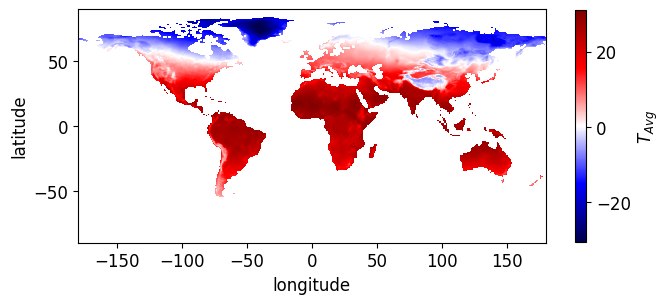

In [161]:
x_coords = TAvg_time.coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
y_coords = TAvg_time.coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name

# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(TAvg_time, cmap='seismic', origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
#plt.title('$T_{Avg}$')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()
plt.show()

In [162]:
d = 15  # Adjust this value to your desired interval length

# Create bins for the 'x' values
TAvg_time_bin = ((TAvg_time// d) * d).copy()

TAvg_time_bin = TAvg_time_bin.rename('bin')

TAvg_time_combined = xr.merge([TAvg_time, TAvg_time_bin])

print(TAvg_time_combined)

unique_bins = xr.DataArray(np.unique(TAvg_time_combined['bin']), dims='bin', name='unique_bins')[:-1]

unique_bins


<xarray.Dataset>
Dimensions:  (lon: 720, lat: 360)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    tmp      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    bin      (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan


<xarray.DataArray 'unique_bins' (bin: 6)>
array([-45., -30., -15.,   0.,  15.,  30.], dtype=float32)
Dimensions without coordinates: bin

## Mask

In [163]:
# TAvg_mask_dict = {}
# for i in unique_bins:
#     TAvg_mask_dict = TAvg_mask_dict + {str(i): (TAvg_time_combined[bin] == i)}

TAvg_mask_dict = {}
for i in list(unique_bins.values):
    TAvg_mask_dict[str(i)] = (TAvg_time_combined.bin == i)
    print(str(i))


-45.0
-30.0
-15.0
0.0
15.0
30.0


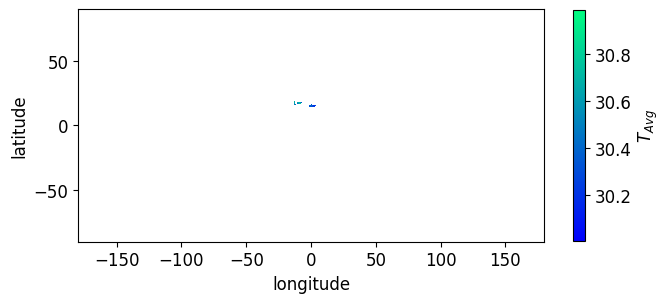

[3.0841652e-04 1.6974086e-03 1.6974357e-03 ... 1.4997987e+01 1.4998149e+01
           nan]


In [164]:
TAvg_mask_dict


x_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lon'].values  # Replace 'your_x_coordinate' with the actual coordinate name
y_coords = TAvg_time.where(TAvg_mask_dict['0.0']).coords['lat'].values  # Replace 'your_y_coordinate' with the actual coordinate name


# Create a heatmap using Matplotlib
plt.figure(figsize=(17/2.46, 5.5))
heatmap = plt.imshow(TAvg_time.where(TAvg_mask_dict['30.0']), cmap='winter', origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()])

cbar = plt.colorbar(heatmap, shrink=0.45, label='$T_{Avg}$')
#plt.title('$T_{Avg}$')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.tight_layout()
plt.show()

print(np.unique(TAvg_time.where(TAvg_mask_dict['0.0'])))


## Create Means

In [168]:
DTR_binned_timeseries = {}
    
for i in list(unique_bins.values):
    TAvg_binned_timeseries[str(i)] = DTR.where(TAvg_mask_dict[str(i)]).mean(dim=['lat', 'lon'])
    print(str(i))

-45.0
-30.0
-15.0
0.0
15.0
30.0


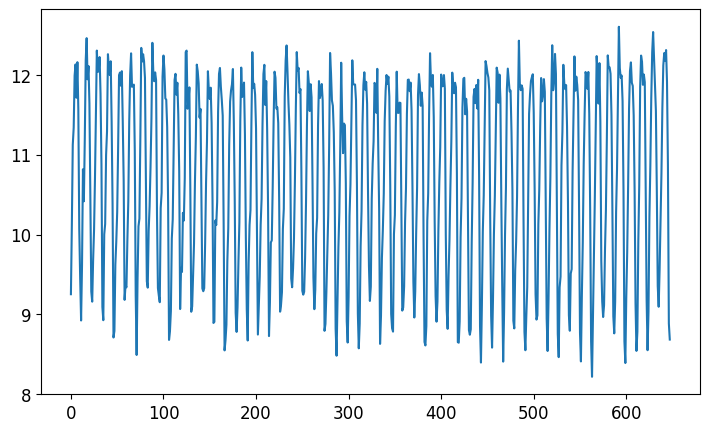

In [172]:
plt.plot(TAvg_binned_timeseries['0.0'])

In [166]:
# angles_in_degrees = TMin_Lat['lat']

# # Convert degrees to radians (cos function in numpy works with radians)
# angles_in_radians = np.radians(angles_in_degrees)

# cosine_values = np.cos(angles_in_radians)

# TMin_Lat.tmn
# weight_fac = len(cosine_values)/np.sum(cosine_values)

# TMin_Lat_temp = TMin_Lat*cosine_values * weight_fac 
# TMax_Lat_temp = TMax_Lat*cosine_values * weight_fac
# TAvg_Lat_temp = TAvg_Lat*cosine_values * weight_fac

In [167]:
TMin_Lat_tot = TMin_Lat_temp.mean('lat')
TMax_Lat_tot = TMax_Lat_temp.mean('lat')
TAvg_Lat_tot = TAvg_Lat_temp.mean('lat')

NameError: name 'TMin_Lat_temp' is not defined

In [ ]:
# TMin_Lat = TMin.mean('lon')
# TMax_Lat = TMax.mean('lon')
# TAvg_Lat = TAvg.mean('lon')

In [ ]:
time_values = TMax['time'].values

In [ ]:
# TMin_Lat_tot = TMin_Lat.sel(lat = slice(67,90)).mean('lat')
# TMax_Lat_tot = TMax_Lat.sel(lat = slice(67,90)).mean('lat')
# TAvg_Lat_tot = TAvg_Lat.sel(lat = slice(67,90)).mean('lat')

In [ ]:
temperature_difference = TMax.tmx - TMin.tmn   # Normale Differenz fü jeden Punkt
temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [ ]:
# monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()
# monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()


In [ ]:
# daily_mean_DTR = temperature_difference_Pol.resample(time='D').mean()
# daily_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='D').mean()


# daily_mean_DTR['month'] = daily_mean_DTR['time'].dt.month
# daily_mean_TAvg['month'] = daily_mean_TAvg['time'].dt.month


In [ ]:

monthly_mean_DTR['month'] = monthly_mean_DTR['time'].dt.month
monthly_mean_TAvg['month'] = monthly_mean_TAvg['time'].dt.month

## Generiere Unterteilungen des Nordpols (Ringe)

In [ ]:
# Creating dict with different averages
TAvg_mean_dict = {}

slices = [(70, 75), (75, 80), (80, 84) ]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = TAvg_Lat.tmp.sel(lat=slice(start, end)).mean('lat')
    TAvg_mean_dict[f'{start}-{end}'] = sliced_data

# Creating dict with different averages
DTR_mean_dict = {}

slices = [(70, 75), (75, 80), (80, 84)]

# Perform the slicing and calculation for each slice
for start, end in slices:
    # Perform the slice and calculate the mean along the 'lat' dimension
    sliced_data = temperature_difference_Lat.sel(lat=slice(start, end)).mean('lat')
    DTR_mean_dict[f'{start}-{end}'] = sliced_data


Plotten

In [ ]:
# # Extract the keys and values from TAvg_mean_dict and DTR_mean_dict
# ta_keys = list(TAvg_mean_dict.keys())

# legend_handles = []

# for i in ta_keys:
#     plt.scatter(TAvg_mean_dict[i], DTR_mean_dict[i], label = i + '°N' )

# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')


# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.png')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
TAvg_Lat_tot

<xarray.Dataset>
Dimensions:  (time: 1464)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2022-12-16
Data variables:
    tmp      (time) float64 -33.35 -32.67 -30.33 -23.56 ... -15.09 -24.52 -28.2
    stn      (time) float64 2.165 2.165 2.165 2.165 ... 4.321 4.518 4.441 4.52

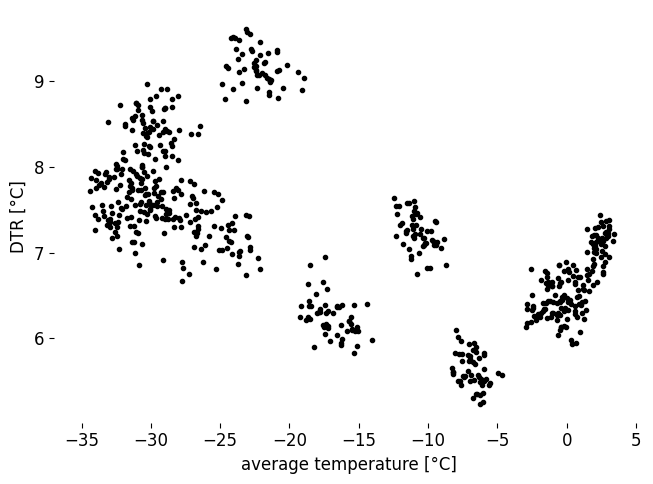

In [ ]:
startdate = '1969'

TAvg_Lat_tot_after_1970 = TAvg_Lat_tot.sel(time=TAvg_Lat_tot['time'] > pd.to_datetime(startdate))
DTR_after_1970 = temperature_difference_Pol.sel(time=temperature_difference_Pol['time'] > pd.to_datetime(startdate))




# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
lines1, labels1 = ax1.get_legend_handles_labels()
#ax1.legend(lines1, labels1, loc='best')

# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_TAvg_DTR_month.pdf')
# plt.savefig('CRU_data_TAvg_yearly1970.png',dpi = 300)
plt.show()



In [ ]:
month_masks = {}
for month in range(1, 13):
    month_mask = TAvg_Lat_tot_after_1970['time'].dt.month == month
    month_masks[month] = month_mask

In [ ]:
# # Set the color palette to colorblind
# sns.set_palette("colorblind")

# # Get the color list from the palette
# colors = sns.color_palette()+ ['black', 'lightgreen']

# # Print or use the colors as needed
# print(len(colors))

# fig, ax = plt.subplots()
# for i, color in enumerate(colors):
#     ax.bar(i, 1, color=color, label=f"Color {i+1}")

# ax.set_xticks(range(len(colors)))
# ax.set_xticklabels([f"Color {i+1}" for i in range(len(colors))])
# ax.set_yticks([])
# ax.legend()

# plt.show()

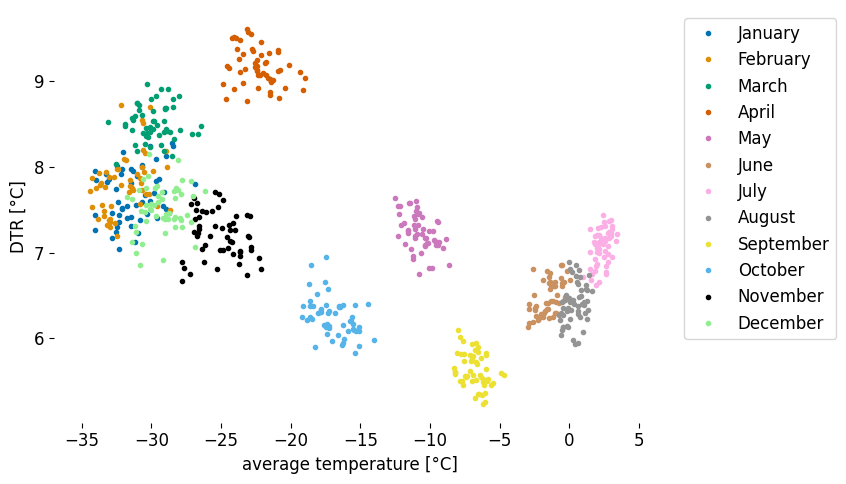

In [ ]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(22 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
for i in range(1,13):
    # Apply the mask
    masked_TAvg = TAvg_Lat_tot_after_1970.tmp.where(month_masks[i], drop=True)
    masked_DTR = DTR_after_1970.where(month_masks[i], drop=True)

    # Plot the masked data
    ax1.plot(masked_TAvg, masked_DTR, marker='.', linestyle='', color = colors[i-1], label= month_label[i-1])


# ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the values based on your layout
# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_Month_DTR_TAvg_legend.pdf')
plt.savefig('CRU_data_Month_DTR_TAvg_legend.png',dpi = 300)
plt.show()


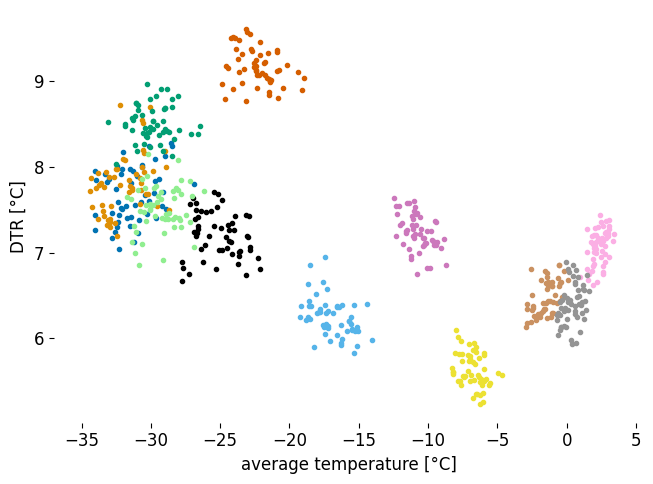

In [ ]:
# Create the first plot
fig1, ax1 = plt.subplots(figsize=(17 / 2.54, 5))



# TAvg_Lat.tmp
# Plot the data for the first plot
for i in range(1,13):
    # Apply the mask
    masked_TAvg = TAvg_Lat_tot_after_1970.tmp.where(month_masks[i], drop=True)
    masked_DTR = DTR_after_1970.where(month_masks[i], drop=True)

    # Plot the masked data
    ax1.plot(masked_TAvg, masked_DTR, marker='.', linestyle='', color = colors[i-1], label= month_label[i-1])


# ax1.plot(TAvg_Lat_tot_after_1970.tmp, DTR_after_1970, marker='.', linestyle='', color='black', label='Average Temperature')
ax1.set_xlabel('average temperature [°C]')
ax1.set_ylabel('DTR [°C]', color='black')

# Set the x-axis limit for the first plot
ax1.set_xlim(-37,)

# Remove the top and right spines for the first plot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Add a legend to the first plot
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the values based on your layout
# Show the first plot
plt.tight_layout()
plt.savefig('CRU_data_Month_DTR_TAvg_noLegend.pdf')
plt.savefig('CRU_data_Month_DTR_TAvg_noLegend.png',dpi = 300)
plt.show()
